# <a id='toc1_'></a>[UCRB PET Sensitivity](#toc0_)
Author: Daniel Hogan

Created: September 7, 2023

This notebook will look at how sensitive potential evapotranspiration is to changes in precipitation over the Upper Colorado River basin between 1964 and 2022. We employ a strategy of looking at the average gradient in the relationship to determine how sensitive one variable is to another, since they both estimate the same quanity (water).

**Table of contents**<a id='toc0_'></a>    
- [UCRB PET Sensitivity](#toc1_)    
    - [Imports](#toc1_1_1_)    
    - [PPT Data](#toc1_1_2_)    
    - [PET Data](#toc1_1_3_)    
      - [Calculate seasonal PET](#toc1_1_3_1_)    
    - [Pull in streamflow categorizations](#toc1_1_4_)    
- [Pull in daily streamlow and calaculate percentage change](#toc2_)    
    - [Figure to demonstrate the influence of ΔPET and ΔSpring P on deficits in Q since 2000.](#toc2_1_1_)    
    - [Plot to illustrate sensitivity of PET ti change in P](#toc2_1_2_)    
    - [Quick calculation of how much area the selected headwater basins cover compared to the whole area of the UCRB](#toc2_1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_1_'></a>[Imports](#toc0_)

In [1]:
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib as mpl
# from pyeto import fao
import numpy as np
import scipy.stats as stats

In [2]:
# Read in the HCDN boundaries
hcdn_boundaries = gpd.read_file('../data/geodata/ucrb_selected_basins.geojson')
hcdn_boundaries=hcdn_boundaries.set_crs(epsg=32613,allow_override=True)

ucrb_boundary = gpd.read_file('../data/geodata/Upper_Colorado_River_Basin_Boundary.json')
ucrb_boundary=ucrb_boundary.to_crs(epsg=32613)


### <a id='toc1_1_2_'></a>[PPT Data](#toc0_)

In [3]:
# Open PRISM precipitation data
prism_ppt = rxr.open_rasterio('../data/precipdata/prism_4km_ucrb.nc')
# convert crs to match the UCRB boundary
# prism_ppt = prism_ppt.rio.reproject(4326)
prism_ppt = prism_ppt.where(prism_ppt>=0,drop=True)
hcdn_prism_ppt = prism_ppt.rio.clip(hcdn_boundaries.geometry)

In [4]:
ucrb_spring_ppt = prism_ppt.where((prism_ppt.month.dt.month>=3) & (prism_ppt.month.dt.month<=5),drop=True).groupby('month.year').sum('month').sel(year=slice(1964,2022))
ucrb_spring_ppt.name = 'ppt'

In [5]:
hcdn_prism_ppt.name = 'ppt'
# get water year precipitation totals
hcdn_prism_ppt_wy = hcdn_prism_ppt.copy()
hcdn_prism_ppt_wy['WY'] = hcdn_prism_ppt_wy.month.dt.year.where(hcdn_prism_ppt_wy.month.dt.month < 10, hcdn_prism_ppt_wy.month.dt.year + 1)
hcdn_prism_ppt_wy = hcdn_prism_ppt_wy.where(hcdn_prism_ppt_wy>=0,np.nan)
hcdn_prism_ppt_wy = hcdn_prism_ppt_wy.groupby('WY').sum('month')
# replace 0 with nan
hcdn_prism_ppt_wy = hcdn_prism_ppt_wy.where(hcdn_prism_ppt_wy>0,np.nan)


In [6]:
# get seasonal precipitation totals
hcdn_prism_ppt_spring = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([3,4,5]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))
hcdn_prism_ppt_summer = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([6,7,8]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))
hcdn_prism_ppt_fall = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([9,10,11]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))
hcdn_prism_ppt_winter = hcdn_prism_ppt.where(hcdn_prism_ppt.month.dt.month.isin([12,1,2]),drop=True).groupby('month.year').sum(dim='month').sel(year=slice(1964,2022))

hcdn_prism_ppt_spring = hcdn_prism_ppt_spring.where(hcdn_prism_ppt_spring>0,drop=True)
hcdn_prism_ppt_summer = hcdn_prism_ppt_summer.where(hcdn_prism_ppt_summer>0,drop=True)
hcdn_prism_ppt_fall = hcdn_prism_ppt_fall.where(hcdn_prism_ppt_fall>0,drop=True)
hcdn_prism_ppt_winter = hcdn_prism_ppt_winter.where(hcdn_prism_ppt_winter>0,drop=True)

### <a id='toc1_1_3_'></a>[PET Data](#toc0_)

In [7]:
# ERA5 PET
era5_et = xr.open_dataset('../data/etdata/ERA5_pet_et_clouds.nc')
era5_et = era5_et.rio.write_crs(4326)
# reproject to 32613
era5_et = era5_et.rio.reproject(32613)
era5_et = era5_et.rio.clip(ucrb_boundary.geometry)
# convert e and pev to mm/month from -1 * m/day by multiplying by days in each month
era5_et['month_days'] = era5_et.time.dt.days_in_month
era5_et['e'] = era5_et['e'] * era5_et['month_days'] * 1000 * -1
era5_et['pev'] = era5_et['pev'] * era5_et['month_days'] * 1000 * -1

In [8]:
# CRU PET
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
cru_et = cru_et.rio.write_crs(4326)
# reproject to 32613
cru_et = cru_et.rio.reproject(32613)
# clip to HCDN boudnaries
hcdn_cru_et = cru_et.rio.clip(hcdn_boundaries.geometry)
hcdn_cru_et = hcdn_cru_et.where(hcdn_cru_et>0,np.nan)

In [9]:
# ERA5 energy only PET
era5_ee_et = xr.open_dataset('../data/etdata/ERA5_energy_only_clipped.nc')
era5_ee_et = era5_ee_et.rio.write_crs(4326)
# reproject to 32613
era5_ee_et = era5_ee_et.rio.reproject(32613)
# clip to HCDN boudnaries
hcdn_era5_ee_et = era5_ee_et.rio.clip(ucrb_boundary.geometry)
hcdn_era5_ee_et = hcdn_era5_ee_et.where(hcdn_era5_ee_et>0,np.nan)

In [10]:
# ERA5 land Priestley-Taylor PET
era5_pt_et = xr.open_dataset('../data/etdata/ERA5-Land-PT-PET.nc')
era5_pt_et = era5_pt_et.rio.write_crs(4326)
# reproject to 32613
era5_pt_et = era5_pt_et.rio.reproject(32613)
# clip to HCDN boudnaries
hcdn_era5_pt_et = era5_pt_et.rio.clip(ucrb_boundary.geometry)
hcdn_era5_pt_et = hcdn_era5_pt_et.where(hcdn_era5_pt_et>0,np.nan)

#### <a id='toc1_1_3_1_'></a>[Calculate seasonal PET](#toc0_)

In [17]:
def seasonal_pet(ds, months, variable):
    if variable is None:
        pet = ds.where(ds['time'].dt.month.isin(months),drop=True).groupby('time.year').sum('time')
        pet = pet.where(pet>0,np.nan)
    else:
        # calculate the seasonal PET for each year
        pet = ds.where(ds['time'].dt.month.isin(months),drop=True).groupby('time.year').sum('time')[variable]
        pet = pet.where(pet>0,np.nan)
    return pet
# calculate the spring totals for each year
era5_et_spring = seasonal_pet(era5_et, [3,4,5], 'pev').sel(year=slice(1964,2022))
cru_et_spring = seasonal_pet(hcdn_cru_et, [3,4,5], 'pet').sel(year=slice(1964,2022))
era5_ee_et_spring = seasonal_pet(hcdn_era5_ee_et, [3,4,5], 'et_eo').sel(year=slice(1964,2022))
era5_pt_et_spring = seasonal_pet(hcdn_era5_pt_et, [3,4,5], 'pet_pt').sel(year=slice(1964,2022))

# calculate the summer totals for each year
era5_et_summer = seasonal_pet(era5_et, [6,7,8], 'pev').sel(year=slice(1964,2022))
cru_et_summer = seasonal_pet(hcdn_cru_et, [6,7,8], 'pet').sel(year=slice(1964,2022))
era5_ee_et_summer = seasonal_pet(hcdn_era5_ee_et, [6,7,8], 'et_eo').sel(year=slice(1964,2022))
era5_pt_et_summer = seasonal_pet(hcdn_era5_pt_et, [6,7,8], 'pet_pt').sel(year=slice(1964,2022))

# calculate the fall totals for each year
era5_et_fall = seasonal_pet(era5_et, [9,10,11], 'pev').sel(year=slice(1964,2021))
cru_et_fall = seasonal_pet(hcdn_cru_et, [9,10,11], 'pet').sel(year=slice(1964,2021))
era5_ee_et_fall = seasonal_pet(hcdn_era5_ee_et, [9,10,11], 'et_eo').sel(year=slice(1964,2021))
era5_pt_et_fall = seasonal_pet(hcdn_era5_pt_et, [9,10,11], 'pet_pt').sel(year=slice(1964,2021))

# calculate the winter totals for each year
era5_et_winter = seasonal_pet(era5_et, [12,1,2], 'pev').sel(year=slice(1964,2022))
cru_et_winter = seasonal_pet(hcdn_cru_et, [12,1,2], 'pet').sel(year=slice(1964,2022))
era5_ee_et_winter = seasonal_pet(hcdn_era5_ee_et, [12,1,2], 'et_eo').sel(year=slice(1964,2022))
era5_pt_et_winter = seasonal_pet(hcdn_era5_pt_et, [12,1,2], 'pet_pt').sel(year=slice(1964,2022))


In [154]:
import glob
files = glob.glob('../data/etdata/P-LSH_ET/*')
ds_list = []
for file in files:
    year = file[-7:-3]
    dates = pd.date_range(start=f'{year}-01-01',end=f'{year}-12-31',freq='M')
    crut4 = xr.open_dataset(file)
    # replace time with dates
    crut4['time'] = dates
    crut4 = crut4.rio.write_crs(4326)
    # change the name of LAT to y and LON to x
    crut4 = crut4.rename({'LAT':'y','LON':'x'})
    crut4 = crut4.rio.reproject(32613)
    crut4 = crut4.rio.clip(hcdn_boundaries.geometry)
    ds_list.append(crut4)
crut4_et = xr.concat(ds_list,dim='time').sortby('time')


(105.0, 165.0)

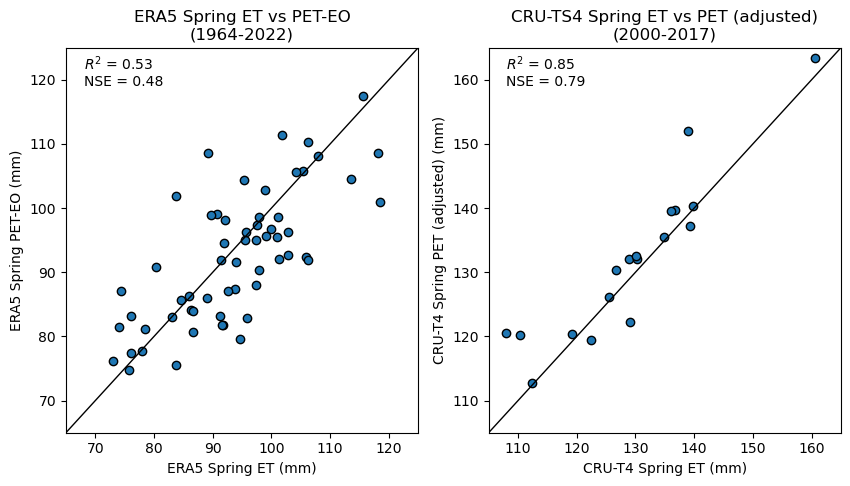

In [182]:
era5_spring_pet = seasonal_pet(hcdn_era5_ee_et, [3,4,5], 'et_eo_adj').sel(year=slice(1964,2022)).rio.write_crs('32613').rio.clip(hcdn_boundaries.geometry).mean(dim=['y','x'])/2 +60
crut4_spring_pet = seasonal_pet(hcdn_era5_ee_et, [3,4,5], 'et_eo_zero').sel(year=slice(1996,2013)).rio.write_crs('32613').rio.clip(hcdn_boundaries.geometry).mean(dim=['y','x'])-130
era5_spring_et = seasonal_pet(era5_et, [3,4,5], 'e').sel(year=slice(1964,2022)).rio.write_crs('32613').rio.clip(hcdn_boundaries.geometry).mean(dim=['y','x'])
crut4_spring_et = seasonal_pet(crut4_et, [3,4,5], 'monthly_ET').mean(dim=['y','x']).sel(year=slice(1996,2013))
# filter era5_spring_et to only include cells in era5_ee_et_spring

slope, intercept, r_value, p_value, std_err = stats.linregress(era5_spring_pet.values,era5_spring_et.values)
# print the NSE
nse = 1 - (np.sum((era5_spring_et.values - era5_spring_pet.values)**2) / np.sum((era5_spring_et.values - np.mean(era5_spring_et.values))**2))
# make a scatter plot of these two variables against each other
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax = axs[0]
ax.scatter(era5_spring_et.values,era5_spring_pet.values, ec='black')
# print the r2 and NSE in the top left corner
ax.text(0.05, 0.90, f'$R^2$ = {r_value**2:.2f}\nNSE = {nse:.2f}', transform=ax.transAxes)

# add a 1:1 line
ax.plot([65, 150], [65, 150], color='black', linewidth=1)
ax.set_xlabel('ERA5 Spring ET (mm)')
ax.set_ylabel('ERA5 Spring PET-EO (mm)')
ax.set_title('ERA5 Spring ET vs PET-EO\n(1964-2022)')
ax.set_xlim(65,125)
ax.set_ylim(65,125)


slope, intercept, r_value, p_value, std_err = stats.linregress(crut4_spring_pet.values,crut4_spring_et.values)
# print the NSE
nse = 1 - (np.sum((crut4_spring_et.values - crut4_spring_pet.values)**2) / np.sum((crut4_spring_et.values - np.mean(crut4_spring_et.values))**2))
ax = axs[1]
ax.scatter(crut4_spring_et.values,crut4_spring_pet.values, ec='black')
# add a 1:1 line
ax.plot([105, 165], [105, 165], color='black', linewidth=1, label='1:1 line')
# print the r2 and NSE in the top left corner
ax.text(0.05, 0.90, f'$R^2$ = {r_value**2:.2f}\nNSE = {nse:.2f}', transform=ax.transAxes)
ax.set_ylabel('CRU-T4 Spring PET (adjusted) (mm)')
ax.set_xlabel('CRU-T4 Spring ET (mm)')

ax.set_title('CRU-TS4 Spring ET vs PET (adjusted)\n(2000-2017)')
ax.set_xlim(105,165)
ax.set_ylim(105,165)



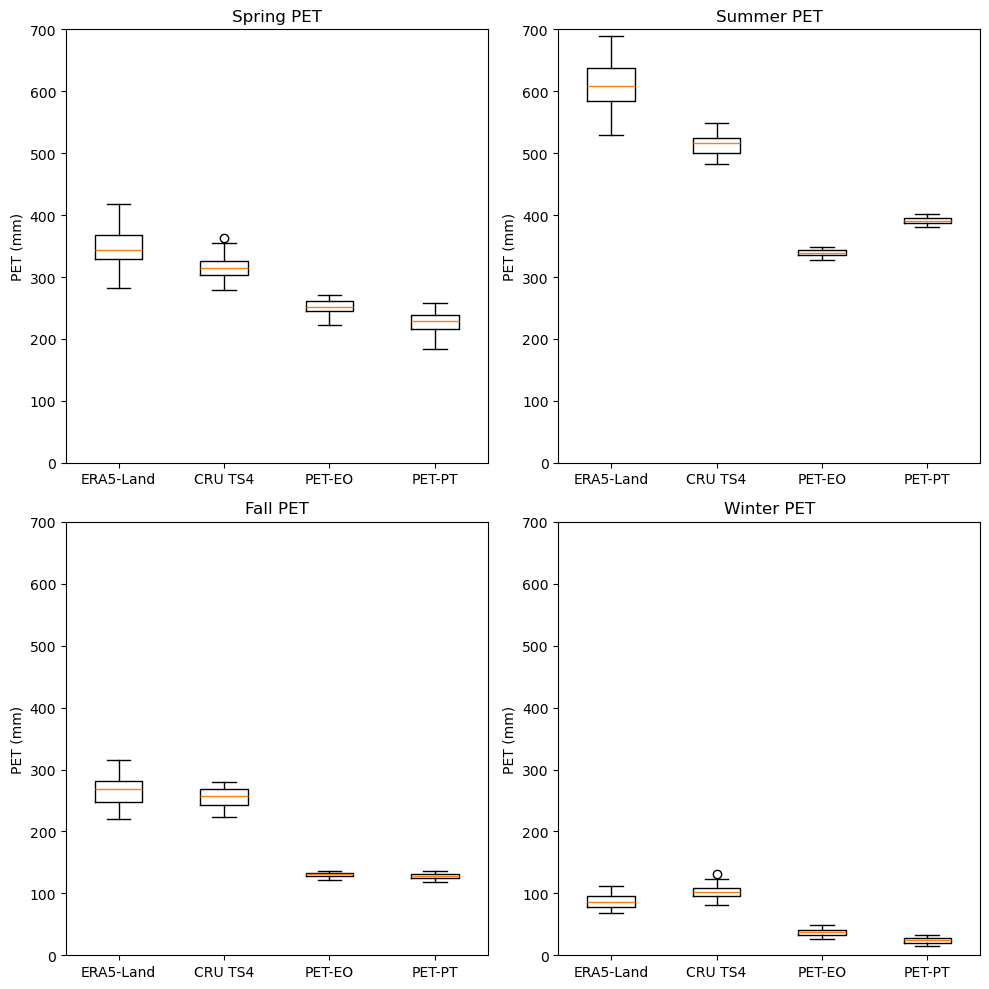

In [12]:
# calcuye the spatial mean across the basins and plot boxplots for each data type and season
era5_et_spring_mean = era5_et_spring.mean(dim=['y','x'])
cru_et_spring_mean = cru_et_spring.mean(dim=['y','x'])
era5_ee_et_spring_mean = era5_ee_et_spring.mean(dim=['y','x'])
era5_pt_et_spring_mean = era5_pt_et_spring.mean(dim=['y','x'])

era5_et_summer_mean = era5_et_summer.mean(dim=['y','x'])
cru_et_summer_mean = cru_et_summer.mean(dim=['y','x'])
era5_ee_et_summer_mean = era5_ee_et_summer.mean(dim=['y','x'])
era5_pt_et_summer_mean = era5_pt_et_summer.mean(dim=['y','x'])

era5_et_fall_mean = era5_et_fall.mean(dim=['y','x'])
cru_et_fall_mean = cru_et_fall.mean(dim=['y','x'])
era5_ee_et_fall_mean = era5_ee_et_fall.mean(dim=['y','x'])
era5_pt_et_fall_mean = era5_pt_et_fall.mean(dim=['y','x'])

era5_et_winter_mean = era5_et_winter.mean(dim=['y','x'])
cru_et_winter_mean = cru_et_winter.mean(dim=['y','x'])
era5_ee_et_winter_mean = era5_ee_et_winter.mean(dim=['y','x'])
era5_pt_et_winter_mean = era5_pt_et_winter.mean(dim=['y','x'])

# plot a boxplot for the spring PET for each dataset
fig, axs = plt.subplots(ncols=2, nrows=2, tight_layout=True, figsize=(10,10))    

ax = axs[0,0]
ax.boxplot([era5_et_spring_mean, cru_et_spring_mean, era5_ee_et_spring_mean, era5_pt_et_spring_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Spring PET')

ax = axs[0,1]
ax.boxplot([era5_et_summer_mean, cru_et_summer_mean, era5_ee_et_summer_mean, era5_pt_et_summer_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Summer PET')

ax = axs[1,0]
ax.boxplot([era5_et_fall_mean, cru_et_fall_mean, era5_ee_et_fall_mean, era5_pt_et_fall_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Fall PET')

ax = axs[1,1]
ax.boxplot([era5_et_winter_mean, cru_et_winter_mean, era5_ee_et_winter_mean, era5_pt_et_winter_mean])
ax.set_xticklabels(['ERA5-Land', 'CRU TS4', 'PET-EO','PET-PT'])
ax.set_ylabel('PET (mm)')
ax.set_title('Winter PET')

# for all set y axis to 0 to 700
for ax in axs.flat:
    ax.set_ylim(0,700)

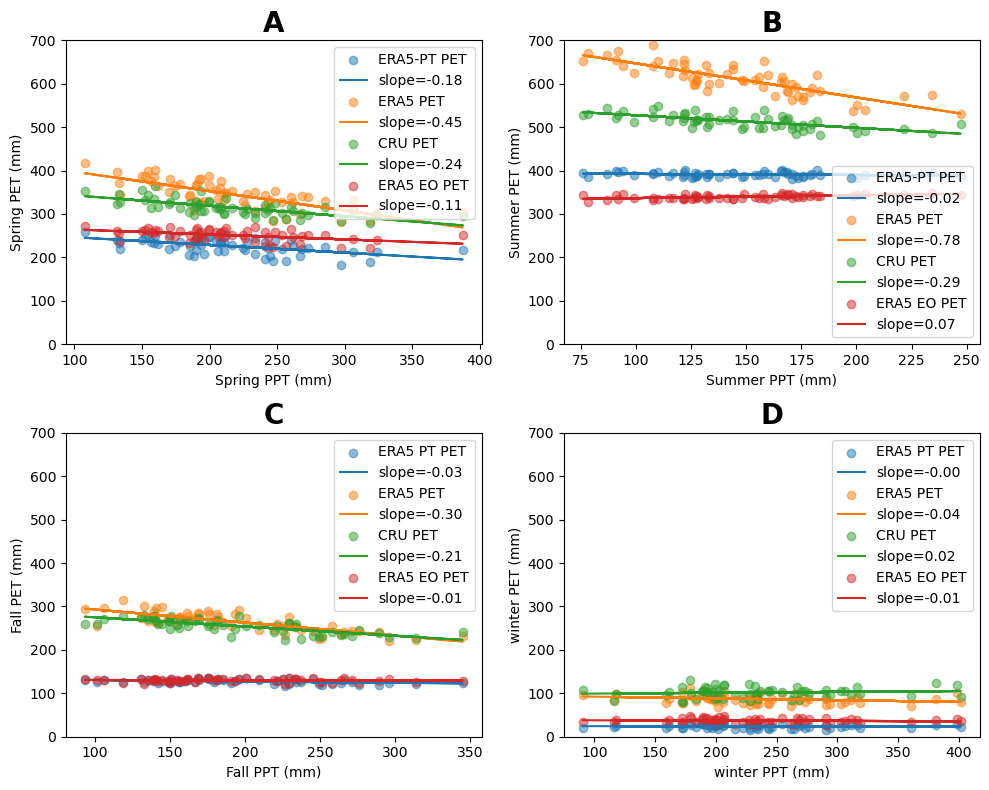

In [13]:
fig, axs = plt.subplots(ncols=2, nrows=2, tight_layout=True, figsize=(10,8))
ax = axs[0,0]
ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            era5_pt_et_spring_mean, label='ERA5-PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = era5_pt_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            era5_et_spring_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = era5_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            cru_et_spring_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = cru_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_spring.mean(dim=['x','y']).values,
            era5_ee_et_spring_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_spring.mean(dim=['x','y']).values
y = era5_ee_et_spring_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('Spring PPT (mm)')
ax.set_ylabel('Spring PET (mm)')
ax.legend()

# summer
ax = axs[0,1]
ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            era5_pt_et_summer_mean, label='ERA5-PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = era5_pt_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            era5_et_summer_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = era5_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            cru_et_summer_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = cru_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_summer.mean(dim=['x','y']).values,
            era5_ee_et_summer_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_summer.mean(dim=['x','y']).values
y = era5_ee_et_summer_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('Summer PPT (mm)')
ax.set_ylabel('Summer PET (mm)')
ax.legend()

# fall
ax = axs[1,0]
ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            era5_pt_et_fall_mean, label='ERA5 PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = era5_pt_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            era5_et_fall_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = era5_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            cru_et_fall_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = cru_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values,
            era5_ee_et_fall_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_fall.mean(dim=['x','y']).sel(year=slice(1964,2021)).values
y = era5_ee_et_fall_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('Fall PPT (mm)')
ax.set_ylabel('Fall PET (mm)')
ax.legend()

# winter
ax = axs[1,1]
ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            era5_pt_et_winter_mean, label='ERA5 PT PET',alpha=0.5)
# add regression line and label with slope
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = era5_pt_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            era5_et_winter_mean, label='ERA5 PET',alpha=0.5)
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = era5_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            cru_et_winter_mean, label='CRU PET',alpha=0.5)
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = cru_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
# standard error of the slope
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.scatter(hcdn_prism_ppt_winter.mean(dim=['x','y']).values,
            era5_ee_et_winter_mean, label='ERA5 EO PET',alpha=0.5)
x = hcdn_prism_ppt_winter.mean(dim=['x','y']).values
y = era5_ee_et_winter_mean.values
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
se = results.bse[1]
r2 = results.rsquared
ax.plot(x[:,1], intercept + slope*x[:,1], label=f'slope={slope:.2f}')

ax.set_xlabel('winter PPT (mm)')
ax.set_ylabel('winter PET (mm)')
ax.legend()

labels = ['A', 'B', 'C', 'D']
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.set_title(f'{labels[i]}', fontweight='bold', fontsize=20)
    ax.set_ylim(0,700)


In [14]:
cru_et = xr.open_dataset('../data/etdata/CRU_UCRB_Monthly_PET_1963_2022.nc')
# clip to HCDN boudnaries
hcdn_cru_et = cru_et
hcdn_cru_et = hcdn_cru_et.where(hcdn_cru_et>0,np.nan)
# calculate the mean spring PET for the HCDN basins
hcdn_spring_pet_cru = hcdn_cru_et.where(hcdn_cru_et['time'].dt.month.isin([3,4,5]),drop=True).groupby('time.year').sum('time')
hcdn_spring_pet_cru = hcdn_spring_pet_cru.where(hcdn_spring_pet_cru>0,np.nan)
# get the spatial mean of the spring PET for the HCDN basins
hcdn_spring_pet_cru_mean = hcdn_spring_pet_cru.mean(dim=['x','y']).sel(year=slice(1964,2022)).pet

In [15]:
# for each hcdn basin, calculate the average and std of dPET/dPPT for spring
# dpet_dppt_df = pd.DataFrame(index=hcdn_boundaries.STAID.values,
#                             columns=['era5_mean','era5_std','cru_mean','cru_std','gleam_mean','gleam_std', 'era5_ee_mean', 'era5_ee_std'])
dpet_dppt_df = pd.DataFrame(index=hcdn_boundaries.STAID.values,
                            columns=['era5_mean','era5_std', 'era5_pt_mean', 'era5_pt_std','era5_ee_mean', 'era5_ee_std'])
wy_prism_ppt= pd.DataFrame(index=hcdn_prism_ppt_wy.sel(WY=slice(1964,2022)).WY.values,
                          columns=hcdn_boundaries.STAID.values)
spring_prism_ppt = pd.DataFrame(index=hcdn_prism_ppt_spring.sel(year=slice(1964,2022)).year.values,
                            columns=hcdn_boundaries.STAID.values)
spring_pet = pd.DataFrame(index=hcdn_prism_ppt_wy.sel(WY=slice(1964,2022)).WY.values,
                          columns=hcdn_boundaries.STAID.values)
                          
for basin in hcdn_boundaries.STAID:
    b = hcdn_boundaries[hcdn_boundaries.STAID==basin]
    # clip the prism ppt to the basin
    ppt = ucrb_spring_ppt.rio.clip(b.geometry, all_touched=True)
    ppt = ppt.where(ppt>0,drop=True)
    try:
        # clip the PET to the basin for ERA5 and CRU
        era5_pet = era5_et_spring.rio.clip(b.geometry, all_touched=True)
        # cru_pet = cru_et_spring.rio.clip(b.geometry, all_touched=True)
        era5_pt_pet = era5_pt_et_spring.rio.clip(b.geometry, all_touched=True)
        era5_ee_pet = era5_ee_et_spring.rio.clip(b.geometry, all_touched=True)
        # calculate the slope and error of the slope
        x = ppt.mean(dim=['x','y']).values
        wy_prism_ppt[basin] = x
        spring_prism_ppt[basin] = x
        y1 = era5_pet.mean(dim=['x','y']).values
        # y2 = cru_pet.mean(dim=['x','y']).values
        y3 = era5_pt_pet.mean(dim=['x','y']).values
        y4 = era5_ee_pet.mean(dim=['x','y']).values
        spring_pet[basin] = y1

        x = sm.add_constant(x)
       
        model1 = sm.OLS(y1,x)
        results1 = model1.fit()
        slope1 = results1.params[1]
        std_err1 = results1.bse[1]

        # model2 = sm.OLS(y2,x)
        # results2 = model2.fit()
        # slope2 = results2.params[1]
        # std_err2 = results2.bse[1]
        model3 = sm.OLS(y3,x)
        results3 = model3.fit()
        slope3 = results3.params[1]
        std_err3 = results3.bse[1]

        model4 = sm.OLS(y4,x)
        results4 = model4.fit()
        slope4 = results4.params[1]
        std_err4 = results4.bse[1]


    except:
        # get the nearest grid cell to the centroid of the basin
        print(basin)
        ppt = ucrb_spring_ppt.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
            
        era5_pet = era5_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
        if basin == '09312600':
            era5_pet = era5_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='bfill')
        # cru_pet = cru_et_spring.dropna(dim='y',how='all').dropna(dim='x',how='all')
        # cru_pet = cru_pet.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='nearest')
        era5_pt_pet = era5_pt_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')
        era5_ee_pet = era5_ee_et_spring.sel(x=b.geometry.centroid.x.values[0],y=b.geometry.centroid.y.values[0],method='nearest')  
       
        # if len(cru_pet) == 0:
        #     cru_pet = cru_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='ffill')
        #     if len(cru_pet) == 0:
        #         cru_pet = cru_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='bfill')
        # if len(gleam_pet) == 0:
        #     gleam_pet = gleam_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='ffill')
        #     if len(gleam_pet) == 0:
        #         gleam_pet = gleam_et_spring.sel(y=b.geometry.centroid.y.values[0],x=b.geometry.centroid.x.values[0],method='bfill')
    
        # caclulate the slope and error of the slope
        x = ppt.values
        wy_prism_ppt[basin] = x
        spring_prism_ppt[basin] = x
        y1 = era5_pet.values
        # y2 = cru_pet.values
        y3 = era5_pt_pet.values
        y4 = era5_ee_pet.values
        spring_pet[basin] = y1


        x = sm.add_constant(x)

        model1 = sm.OLS(y1,x)
        results1 = model1.fit()
        slope1 = results1.params[1]
        std_err1 = results1.bse[1]
        
        # model2 = sm.OLS(y2,x)
        # results2 = model2.fit()
        # slope2 = results2.params[1]
        # std_err2 = results2.bse[1]

        model4 = sm.OLS(y4,x)
        results4 = model4.fit()
        slope4 = results4.params[1]
        std_err4 = results4.bse[1]

        # x = ppt.sel(year=slice(1980,2022)).values
        model3 = sm.OLS(y3,x)
        results3 = model3.fit()
        slope3 = results3.params[1]
        std_err3 = results3.bse[1]


    # dpet_dppt_df.loc[basin] = [slope1, std_err1, slope2, std_err2, slope3, std_err3, slope4, std_err4]
    dpet_dppt_df.loc[basin] = [slope1, std_err1, slope3, std_err3, slope4, std_err4]


### <a id='toc1_1_4_'></a>[Pull in streamflow categorizations](#toc0_)

In [16]:
low = hcdn_boundaries[hcdn_boundaries['elevation_category']=='low'].STAID.to_list()
mid = hcdn_boundaries[hcdn_boundaries['elevation_category']=='medium'].STAID.to_list()
high = hcdn_boundaries[hcdn_boundaries['elevation_category']=='high'].STAID.to_list()

# <a id='toc2_'></a>[Pull in daily streamlow and calaculate percentage change](#toc0_)

For both PET, P, and Q

In [17]:
daily_q = xr.open_dataset('../data/streamflowdata/selected_hcdn_basin_chars_and_daily_q.nc')

In [18]:
q = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')['wy_q_mm']

# calculate the % change during the 2000-2022 period compared to the mean 1964-1999 period
percent_change = 100 *(q-q.sel(water_year=slice(1964,1999)).mean(dim='water_year')) / q.sel(water_year=slice(1964,1999)).mean(dim='water_year')
percent_change_df = percent_change.to_dataframe()
wy_q_perc_change = percent_change_df.reset_index().pivot(index='water_year',columns='site_no',values='wy_q_mm')
wy_prism_ppt_perc_change = 100*(wy_prism_ppt - wy_prism_ppt.loc[1964:1999].mean())/wy_prism_ppt.loc[1964:1999].mean()
pet_anomaly = (spring_pet - spring_pet.loc[1964:1999].mean())/spring_pet.loc[1964:1999].std()

In [19]:
order = ['09110000','09109000','09036000','09035900','09035700','09289500','09026500','09352900','09124500',
         '09010500','09196500','09361500','09165000','09112500','09081600','09032000','09365500',
         '09310500','09277500','09255000','09253000','09223000','09059500','09210500','09188500','09166500',
]
order2 = ['09110000','09109000','09289500','09352900',
         '09196500','09361500','09165000','09112500','09081600','09365500',
         '09310500','09277500','09255000','09223000','09210500','09188500','09166500','09253000'
]

In [20]:
# calculate the % change in spring pet during the 2000-2022 period compared to the mean 1964-1999 period
spring_pet_percent_change = (spring_pet.loc[2000:2022].mean()-spring_pet.loc[1964:1999].mean())

# calculate the % change during the 2000-2022 period compared to the mean 1964-1999 period
percent_change = (q.sel(water_year=slice(2000,2022)).mean(axis=0)-q.sel(water_year=slice(1964,1999)).mean(dim='water_year')) 
percent_change_df = percent_change.to_dataframe()['wy_q_mm']

# calculate the value difference in means
spring_ppt = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')['spring_ppt']
winter_ppt = xr.open_dataset('../data/streamflowdata/selected_hcdn_streamflow_annual.nc')['winter_ppt']
spring_ppt_mean = spring_ppt.sel(water_year=slice(2000,2022)).mean(dim='water_year') - spring_ppt.sel(water_year=slice(1964,1999)).mean(dim='water_year').to_dataframe()['spring_ppt']
winter_ppt_mean = winter_ppt.sel(water_year=slice(2000,2022)).mean(dim='water_year') - winter_ppt.sel(water_year=slice(1964,1999)).mean(dim='water_year').to_dataframe()['winter_ppt']

### <a id='toc2_1_1_'></a>[Figure to demonstrate the influence of ΔPET and ΔSpring P on deficits in Q since 2000.](#toc0_)

20.841227319432974 14.116257701995204 18.887596836301643
-4.531396092447515 14.143753404075774 16.475445581907003


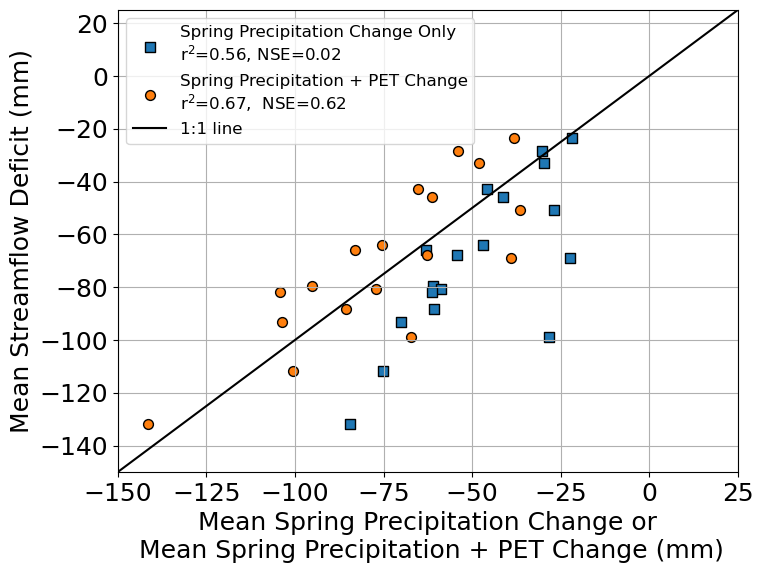

In [24]:
a = (spring_ppt_mean.loc[order2]).to_pandas()
c = (spring_ppt_mean.loc[order2]-spring_pet_percent_change.loc[order2].fillna(0)).to_pandas()
b = percent_change_df.loc[order2]
# make b all negative
# b = b.abs() *-1

fig, ax = plt.subplots(figsize=(8,6))

# add r2 value
x = sm.add_constant(a.values)
model = sm.OLS(b.values,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
# calculate the cumulative bias
cumulative_bias = np.sum(a-b)/len(a)
# calculate the mean absolute error of the data
mae = np.mean(np.abs(results.resid))
# calulate the mean squared error
rmse = np.sqrt(np.mean(results.resid**2))
## calculate NSE
nse = 1 - np.sum((b-a)**2)/np.sum((b-np.mean(b))**2)
print(cumulative_bias, mae, rmse)
r2 = results.rsquared
ax.scatter(a,b, label=f'Spring Precipitation Change Only\nr$^2$={r2:.2f}, NSE={nse:.2f}',s=50, ec='k', marker='s')
# plot the best fit line in orange
# ax.plot(a, intercept + slope*a, color='blue')

x = sm.add_constant(c.values)
model = sm.OLS(b.values,x)
results = model.fit()
slope = results.params[1]
intercept = results.params[0]
# calculate the cumulative bias
cumulative_bias = np.sum(c-b)/len(b)
# calculate the mean absolute error of the data
mae = np.mean(np.abs(results.resid))
# calulate the mean squared error
rmse = np.sqrt(np.mean(results.resid**2))
print(cumulative_bias, mae, rmse)
## calculate NSE
nse = 1 - np.sum((b-c)**2)/np.sum((b-np.mean(b))**2)
r2 = results.rsquared
# calculate the mean absolute error of the data

ax.scatter(c,b, label=f'Spring Precipitation + PET Change\nr$^2$={r2:.2f},  NSE={nse:.2f}',s=50, ec='k', marker='o')
# plot the best fit line in orange
# ax.plot(c, intercept + slope*c, color='orange')

ax.plot([-150,25],[-150,25],color='black', label='1:1 line')
ax.set_xlabel('Mean Spring Precipitation Change or\n Mean Spring Precipitation + PET Change (mm)', size=18)
ax.set_ylabel('Mean Streamflow Deficit (mm)', size=18)

# ax.set_title('Comparing Significant Streamflow Deficit and Precipitation + Spring PET Change\nfor Selected HCDN Basins since 2000')
ax.legend(loc='upper left', fontsize=12)
# increase font size for the x and y axis labels
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlim(-150,25)
ax.set_ylim(-150,25)
ax.grid()



### <a id='toc2_1_2_'></a>[Plot to illustrate sensitivity of PET ti change in P](#toc0_)

/tmp/ipykernel_23671/623217443.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(low+mid+high,rotation=90);


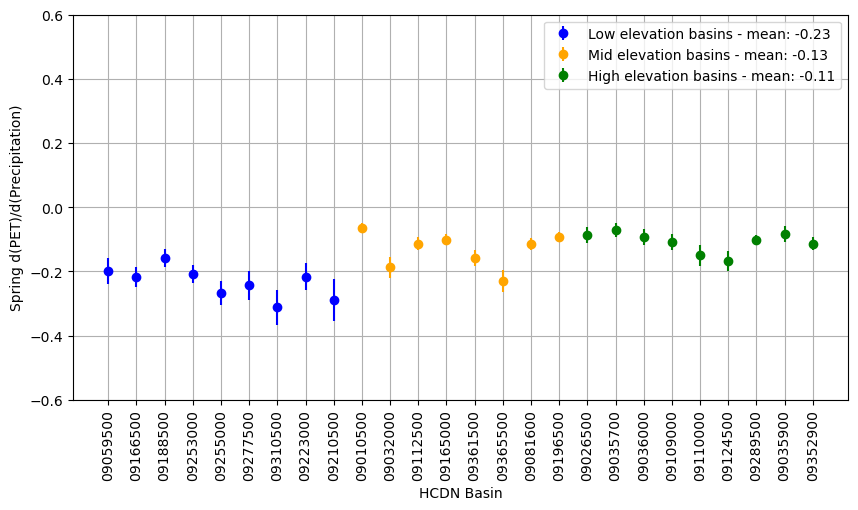

In [212]:
# create a scatter plot of the dPET/dPPT for each basin with the mean values as the point and the std value as the error
fig, ax = plt.subplots(figsize=(10,5))
ax.errorbar(dpet_dppt_df.loc[low].index, 
            dpet_dppt_df.loc[low]['era5_pt_mean'], 
            yerr=dpet_dppt_df.loc[low]['era5_pt_std'], 
            label=f"Low elevation basins - mean: {dpet_dppt_df.loc[low]['era5_pt_mean'].mean():.2f}",
            fmt='o', 
            color='blue')
ax.errorbar(dpet_dppt_df.loc[mid].index,
            dpet_dppt_df.loc[mid]['era5_pt_mean'], 
            yerr=dpet_dppt_df.loc[mid]['era5_pt_std'], 
            label=f"Mid elevation basins - mean: {dpet_dppt_df.loc[mid]['era5_pt_mean'].mean():.2f}",
            fmt='o',
            color='orange')
ax.errorbar(dpet_dppt_df.loc[high].index,
            dpet_dppt_df.loc[high]['era5_pt_mean'], 
            yerr=dpet_dppt_df.loc[high]['era5_pt_std'], 
            label=f"High elevation basins - mean: {dpet_dppt_df.loc[high]['era5_pt_mean'].mean():.2f}",
            fmt='o',
            color='green')
# ax.errorbar(dpet_dppt_df.loc[low].index, 
#             dpet_dppt_df.loc[low]['era5_pt_mean'], 
#             yerr=dpet_dppt_df.loc[low]['era5_pt_std'], 
#             label='Low elevation basins',
#             fmt='s', 
#             color='blue')
# ax.errorbar(dpet_dppt_df.loc[mid].index,
#             dpet_dppt_df.loc[mid]['era5_pt_mean'], 
#             yerr=dpet_dppt_df.loc[mid]['era5_pt_std'], 
#             label='Mid elevation basins',
#             fmt='s',
#             color='orange')
# ax.errorbar(dpet_dppt_df.loc[high].index,
#             dpet_dppt_df.loc[high]['era5_pt_mean'], 
#             yerr=dpet_dppt_df.loc[high]['era5_pt_std'], 
#             label='High elevation basins',
#             fmt='s',
#             color='green')
# plot the deficit for each basin on a twin axis
# ax2 = ax.twinx()
# ax2.plot(percent_change_df.loc[low].index,percent_change_df.loc[low].wy_q_mm,color='red',alpha=0.5, ls='-',marker='o')
# ax2.plot(percent_change_df.loc[mid].index,percent_change_df.loc[mid].wy_q_mm,color='red',alpha=0.5, ls='-',marker='o')
# ax2.plot(percent_change_df.loc[high].index,percent_change_df.loc[high].wy_q_mm,color='red',alpha=0.5, ls='-',marker='o')
# # hide the x-axis labels
# ax2.set_xticklabels([])
# ax2.set_ylabel('Percent Change in Streamflow Volumne since 2000(%)')
# ax2.set_ylim(-40,40)

ax.set_ylabel('Spring d(PET)/d(Precipitation)');
ax.set_xlabel('HCDN Basin');
ax.set_xticklabels(low+mid+high,rotation=90);
# add grid
ax.grid()
ax.legend(loc='upper right');
ax.set_ylim(-0.6,0.6)
# rotate the x labels
plt.xticks(rotation=90);


### <a id='toc2_1_3_'></a>[Quick calculation of how much area the selected headwater basins cover compared to the whole area of the UCRB](#toc0_)

In [213]:
#EPSG code
co_epsg = 32613

# pull in UCRB basin 
ucrb_basin_boundary = gpd.read_file('../basin_characteristics/Upper_Colorado_River_Basin_Boundary.json')
ucrb_basin_boundary = ucrb_basin_boundary.to_crs(co_epsg)
# get the area of the hcdn basins sum divided by ucrb area
hcdn_area = hcdn_boundaries.area.sum()
ucrb_area = ucrb_basin_boundary.area.sum()
hcdn_area/ucrb_area

0.04428857858432073